# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 2048 # Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df.dropna(inplace = True)
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [7]:
df = df.drop(df.columns[[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [8]:
# Normalize all inputs between -1 and 1

train_features = ["mj1-mj2",'mj2','tau21j1','tau21j2']
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 366 batches of 2048 samples each, total 749568 samples
Testset consists of 122 batches of 2048 samples each, total 249856 samples


40

In [9]:
X_train

array([[-0.42749047, -0.9521566 , -0.35413128,  0.659268  ],
       [-0.7308719 , -0.8905885 ,  0.62376225, -0.50855255],
       [-0.98781896, -0.7697842 , -0.11379486,  0.29616988],
       ...,
       [-0.9570126 , -0.8993222 ,  0.04435825,  0.6795753 ],
       [-0.94862   , -0.8611317 ,  0.25767016,  0.27707398],
       [-0.9019917 , -0.7841517 ,  0.40624475,  0.49484193]],
      dtype=float32)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [12]:
generator = make_generator_model()

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(4)) # WGAN: No sigmoid activation in last layer

    return model

In [14]:
discriminator = make_discriminator_model()

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [16]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                250       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [17]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [18]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [19]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [20]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [21]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [22]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [23]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [24]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [25]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [26]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    mj1=[]
    mj2=[]
    tau21j1=[]
    tau21j2=[]
    for i in fakedata:
        mj1.append(i[0])
        mj2.append(i[1])
        tau21j1.append(i[2])
        tau21j2.append(i[3])
    plt.subplot(221)
    plt.hist(df['mj1-mj2'], bins = 50, range = (0, 1000), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(mj1, bins = 50, range = (0, 1000), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.subplot(222)
    plt.hist(df['mj2'], bins = 50, range = (0, 500), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(mj2, bins = 50, range = (0, 500), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.subplot(223)
    plt.hist(df['tau21j1'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(tau21j1, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.subplot(224)
    plt.hist(df['tau21j2'], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(tau21j2, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [27]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [28]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [29]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)


    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging
    
    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()

  1%|▊                                                                             | 10/1000 [01:22<2:15:49,  8.23s/it]


Epoch 10:

Generator training loss: -0.1459163694637395
Discriminator training loss: 0.011871677532644506

Generator validation loss: -0.10774347186088562
Discriminator validation loss: 0.012205712649910177


  2%|█▌                                                                            | 20/1000 [02:26<1:40:13,  6.14s/it]


Epoch 20:

Generator training loss: 0.011089511344666068
Discriminator training loss: 0.007118617963094978

Generator validation loss: -0.021560111403709552
Discriminator validation loss: 0.008085461468178184


  3%|██▎                                                                           | 30/1000 [03:25<1:35:09,  5.89s/it]


Epoch 30:

Generator training loss: -0.09130874399319698
Discriminator training loss: 0.03894259918358971

Generator validation loss: -0.13568495775832504
Discriminator validation loss: 0.03770697687859418


  4%|███                                                                           | 40/1000 [04:24<1:34:03,  5.88s/it]


Epoch 40:

Generator training loss: -0.07322327658289769
Discriminator training loss: 0.026127195069464586

Generator validation loss: -0.07600960129352867
Discriminator validation loss: 0.016589714137867827


  5%|███▉                                                                          | 50/1000 [05:24<1:41:22,  6.40s/it]


Epoch 50:

Generator training loss: -0.15628380202204803
Discriminator training loss: 0.025067437589628167

Generator validation loss: -0.15407509637660669
Discriminator validation loss: 0.0018246282334821145


  6%|████▋                                                                         | 60/1000 [06:41<1:53:55,  7.27s/it]


Epoch 60:

Generator training loss: -0.28143485175455857
Discriminator training loss: 0.028188637823446612

Generator validation loss: -0.28396919174272506
Discriminator validation loss: 0.031743416379465435


  7%|█████▍                                                                        | 70/1000 [07:39<1:30:33,  5.84s/it]


Epoch 70:

Generator training loss: -0.3265370346727918
Discriminator training loss: -0.011235554124334178

Generator validation loss: -0.26624407045176773
Discriminator validation loss: -0.00649168667933125


  8%|██████▏                                                                       | 80/1000 [08:43<1:46:17,  6.93s/it]


Epoch 80:

Generator training loss: -0.40013675090393735
Discriminator training loss: -0.010671924240632704

Generator validation loss: -0.33972949327015484
Discriminator validation loss: -0.014118390287593251


  9%|███████                                                                       | 90/1000 [09:45<1:30:32,  5.97s/it]


Epoch 90:

Generator training loss: -0.10643185744357239
Discriminator training loss: 0.014782494499945767

Generator validation loss: -0.13587143064522353
Discriminator validation loss: 0.029432241285799958


 10%|███████▋                                                                      | 99/1000 [10:53<1:58:39,  7.90s/it]


Epoch 100:

Generator training loss: -0.293314506935943
Discriminator training loss: 0.03831658833176712

Generator validation loss: -0.2784334421157837
Discriminator validation loss: 0.03689890444950491

Epoch 100:


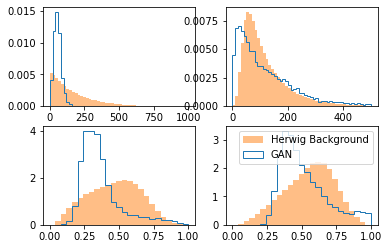

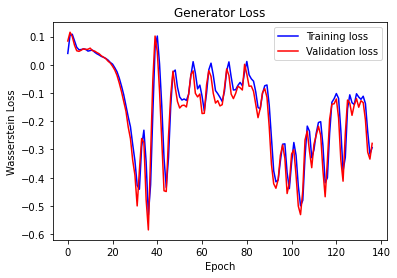

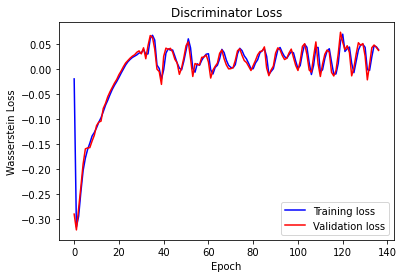

 11%|████████▍                                                                    | 110/1000 [12:13<1:43:47,  7.00s/it]


Epoch 110:

Generator training loss: -0.424277338581007
Discriminator training loss: 0.007045024490742166

Generator validation loss: -0.40086308561387607
Discriminator validation loss: 0.014663771844037702


 12%|█████████▏                                                                   | 120/1000 [13:18<1:24:29,  5.76s/it]


Epoch 120:

Generator training loss: -0.12096891411748088
Discriminator training loss: -0.009140997649363849

Generator validation loss: -0.12422274230200736
Discriminator validation loss: -0.005010304865656329


 13%|██████████                                                                   | 130/1000 [14:11<1:15:14,  5.19s/it]


Epoch 130:

Generator training loss: 0.008056189588626052
Discriminator training loss: 0.06745448292339923

Generator validation loss: -0.005842709780258477
Discriminator validation loss: 0.05822709057724378


 14%|██████████▊                                                                  | 140/1000 [15:00<1:10:48,  4.94s/it]


Epoch 140:

Generator training loss: -0.39930929561130335
Discriminator training loss: 0.04879241545221519

Generator validation loss: -0.3451112252278406
Discriminator validation loss: 0.04217556183088998


 15%|███████████▌                                                                 | 150/1000 [15:50<1:10:34,  4.98s/it]


Epoch 150:

Generator training loss: -0.35666891859203087
Discriminator training loss: -0.000539668372292625

Generator validation loss: -0.3448843333076258
Discriminator validation loss: 0.008098264945743483


 16%|████████████▎                                                                | 160/1000 [16:40<1:10:05,  5.01s/it]


Epoch 160:

Generator training loss: -0.26577925779780404
Discriminator training loss: 0.004794715653350793

Generator validation loss: -0.26765479513856233
Discriminator validation loss: -0.006862079610162583


 17%|█████████████                                                                | 170/1000 [17:30<1:08:18,  4.94s/it]


Epoch 170:

Generator training loss: -0.31740176197283904
Discriminator training loss: 0.03613766325991397

Generator validation loss: -0.3632837619449272
Discriminator validation loss: 0.04743832749787901


 18%|█████████████▊                                                               | 180/1000 [18:20<1:08:10,  4.99s/it]


Epoch 180:

Generator training loss: -0.2561779781931736
Discriminator training loss: -0.010041916427215882

Generator validation loss: -0.28839480388359945
Discriminator validation loss: -0.006094124030749329


 19%|██████████████▋                                                              | 190/1000 [19:17<1:27:19,  6.47s/it]


Epoch 190:

Generator training loss: -0.5882008259739381
Discriminator training loss: 0.007918540754775171

Generator validation loss: -0.6049771479895858
Discriminator validation loss: -0.011884324954914266


 20%|███████████████▎                                                             | 199/1000 [20:11<1:20:03,  6.00s/it]


Epoch 200:

Generator training loss: -0.5367787977059683
Discriminator training loss: 0.04239700571557538

Generator validation loss: -0.5441123706395509
Discriminator validation loss: 0.033638950452574944

Epoch 200:


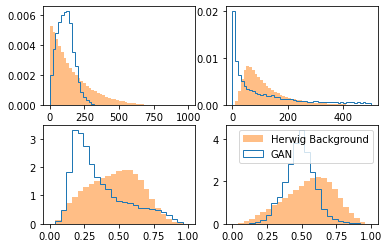

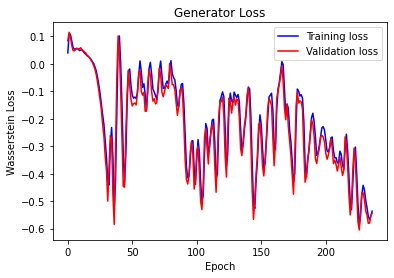

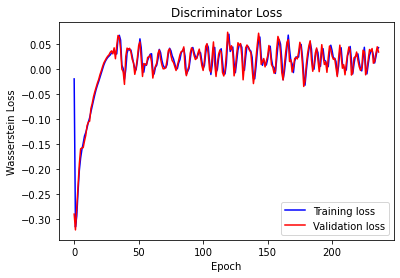

 21%|████████████████▏                                                            | 210/1000 [21:28<1:37:01,  7.37s/it]


Epoch 210:

Generator training loss: -0.46371853384163864
Discriminator training loss: -0.011686379585750375

Generator validation loss: -0.4316406069231815
Discriminator validation loss: -0.021531645025386185


 22%|████████████████▉                                                            | 220/1000 [22:44<1:36:56,  7.46s/it]


Epoch 220:

Generator training loss: -0.31200476178054604
Discriminator training loss: 0.03798703375766105

Generator validation loss: -0.32410713932553276
Discriminator validation loss: 0.04123117536550663


 23%|█████████████████▋                                                           | 230/1000 [23:58<1:34:38,  7.37s/it]


Epoch 230:

Generator training loss: -0.29313017582632805
Discriminator training loss: -0.010514348300620058

Generator validation loss: -0.30888096475210347
Discriminator validation loss: -0.002164342275584025


 24%|██████████████████▍                                                          | 240/1000 [25:10<1:30:46,  7.17s/it]


Epoch 240:

Generator training loss: -0.5014882592555604
Discriminator training loss: 0.031848084618152334

Generator validation loss: -0.4823451872731819
Discriminator validation loss: 0.014687645371209403


 25%|███████████████████▎                                                         | 250/1000 [26:21<1:28:47,  7.10s/it]


Epoch 250:

Generator training loss: -0.30688396535935947
Discriminator training loss: 0.026226613222545596

Generator validation loss: -0.3147560990736133
Discriminator validation loss: 0.0218081156585793


 26%|████████████████████                                                         | 260/1000 [27:32<1:27:23,  7.09s/it]


Epoch 260:

Generator training loss: -0.3084499304248987
Discriminator training loss: 0.02630759551970872

Generator validation loss: -0.3602692453099079
Discriminator validation loss: 0.024764702315671277


 27%|████████████████████▊                                                        | 270/1000 [28:43<1:26:07,  7.08s/it]


Epoch 270:

Generator training loss: -0.5065480326531363
Discriminator training loss: 0.03513755490433245

Generator validation loss: -0.5339911199006878
Discriminator validation loss: 0.017251576075605193


 28%|█████████████████████▌                                                       | 280/1000 [29:54<1:25:33,  7.13s/it]


Epoch 280:

Generator training loss: -0.3645456404796715
Discriminator training loss: 0.014564395546874978

Generator validation loss: -0.3807703305463322
Discriminator validation loss: 0.022692809889062505


 29%|██████████████████████▎                                                      | 290/1000 [31:06<1:25:39,  7.24s/it]


Epoch 290:

Generator training loss: -0.26972622762286597
Discriminator training loss: 0.011136473285988045

Generator validation loss: -0.28957496070470967
Discriminator validation loss: 0.013364713245880653


 30%|███████████████████████                                                      | 299/1000 [32:11<1:24:26,  7.23s/it]


Epoch 300:

Generator training loss: -0.4312705781941857
Discriminator training loss: 0.041022643776065945

Generator validation loss: -0.46863392117570657
Discriminator validation loss: 0.054038449785992745

Epoch 300:


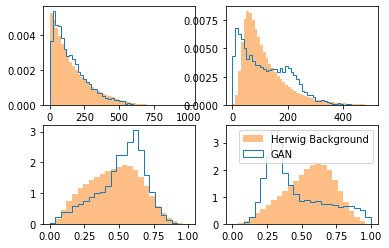

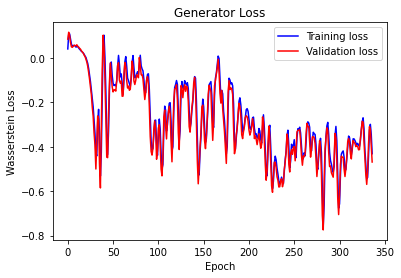

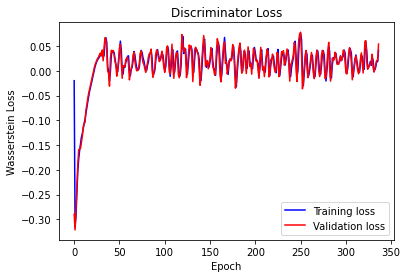

 31%|███████████████████████▊                                                     | 310/1000 [33:31<1:23:21,  7.25s/it]


Epoch 310:

Generator training loss: -0.09009664855856712
Discriminator training loss: 0.04951485976617519

Generator validation loss: -0.08313900696449593
Discriminator validation loss: 0.03268281864307699


 32%|████████████████████████▋                                                    | 320/1000 [34:44<1:22:07,  7.25s/it]


Epoch 320:

Generator training loss: -0.15717080838041877
Discriminator training loss: 0.029506746905886373

Generator validation loss: -0.2109879665687436
Discriminator validation loss: 0.03864144469748755


 33%|█████████████████████████▍                                                   | 330/1000 [35:57<1:21:14,  7.28s/it]


Epoch 330:

Generator training loss: -0.22284820366426894
Discriminator training loss: 0.0008787975729731945

Generator validation loss: -0.22183691307169492
Discriminator validation loss: -0.0021550297473755774


 34%|██████████████████████████▏                                                  | 340/1000 [37:10<1:20:16,  7.30s/it]


Epoch 340:

Generator training loss: -0.23773677871038354
Discriminator training loss: -0.016368501410654032

Generator validation loss: -0.2276540200729839
Discriminator validation loss: -0.028055870829180617


 35%|██████████████████████████▉                                                  | 350/1000 [38:22<1:17:53,  7.19s/it]


Epoch 350:

Generator training loss: -0.2535689588371522
Discriminator training loss: 0.00968560908650779

Generator validation loss: -0.29214062700506116
Discriminator validation loss: 0.01646828327755459


 36%|███████████████████████████▋                                                 | 360/1000 [39:34<1:17:00,  7.22s/it]


Epoch 360:

Generator training loss: -0.4230919775904202
Discriminator training loss: 0.00934287619083144

Generator validation loss: -0.4457419932377143
Discriminator validation loss: 0.011763895218657543


 37%|████████████████████████████▍                                                | 370/1000 [40:47<1:15:45,  7.22s/it]


Epoch 370:

Generator training loss: -0.5018339213289198
Discriminator training loss: 0.006749810581425519

Generator validation loss: -0.4977268068516841
Discriminator validation loss: 0.011330181042869866


 38%|█████████████████████████████▎                                               | 380/1000 [41:59<1:14:34,  7.22s/it]


Epoch 380:

Generator training loss: -0.419899592471253
Discriminator training loss: 0.03131890766274266

Generator validation loss: -0.4353893721689943
Discriminator validation loss: 0.031574245259837534


 39%|██████████████████████████████                                               | 390/1000 [43:11<1:13:36,  7.24s/it]


Epoch 390:

Generator training loss: -0.2155312038754505
Discriminator training loss: -0.03289860638375063

Generator validation loss: -0.24350231446203638
Discriminator validation loss: -0.015795571157006454


 40%|██████████████████████████████▋                                              | 399/1000 [44:16<1:12:34,  7.25s/it]


Epoch 400:

Generator training loss: -0.3675185683809343
Discriminator training loss: 0.025524611031813766

Generator validation loss: -0.380785480385921
Discriminator validation loss: 0.03598521703274035

Epoch 400:


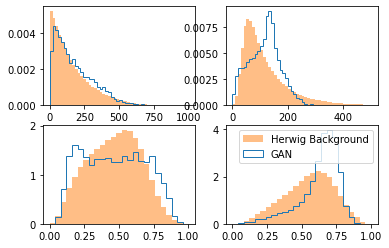

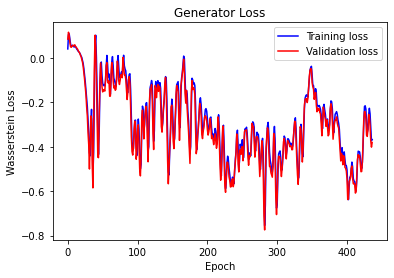

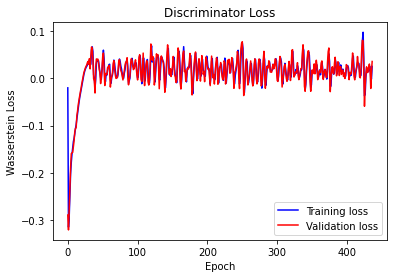

 41%|███████████████████████████████▌                                             | 410/1000 [45:37<1:11:14,  7.25s/it]


Epoch 410:

Generator training loss: -0.2475824194039152
Discriminator training loss: 0.0048227543825658335

Generator validation loss: -0.25463487891877284
Discriminator validation loss: 0.003889008818316411


 42%|████████████████████████████████▎                                            | 420/1000 [46:50<1:10:02,  7.25s/it]


Epoch 420:

Generator training loss: -0.3612769453740511
Discriminator training loss: 0.03232437375426557

Generator validation loss: -0.41320717798881845
Discriminator validation loss: 0.039026262223354126


 43%|█████████████████████████████████                                            | 430/1000 [48:02<1:08:59,  7.26s/it]


Epoch 430:

Generator training loss: -0.5527071915363353
Discriminator training loss: 0.01429213338305502

Generator validation loss: -0.51147482776251
Discriminator validation loss: 0.036874504402073745


 44%|█████████████████████████████████▉                                           | 440/1000 [49:16<1:09:47,  7.48s/it]


Epoch 440:

Generator training loss: -0.3599033681421332
Discriminator training loss: 0.04964297079109674

Generator validation loss: -0.4288161194226781
Discriminator validation loss: 0.0606266904744457


 45%|██████████████████████████████████▋                                          | 450/1000 [50:31<1:09:36,  7.59s/it]


Epoch 450:

Generator training loss: -0.5177352599433211
Discriminator training loss: 0.039056466494641104

Generator validation loss: -0.5414026584781584
Discriminator validation loss: 0.024616257142519853


 46%|███████████████████████████████████▍                                         | 460/1000 [51:43<1:05:12,  7.25s/it]


Epoch 460:

Generator training loss: -0.35946602223675106
Discriminator training loss: -0.008075614972469457

Generator validation loss: -0.3617641156325575
Discriminator validation loss: -0.0031194554197651594


 47%|████████████████████████████████████▏                                        | 470/1000 [52:56<1:04:17,  7.28s/it]


Epoch 470:

Generator training loss: -0.5461942512806648
Discriminator training loss: 0.03561133815874498

Generator validation loss: -0.5861552054764795
Discriminator validation loss: 0.05785115615876972


 48%|█████████████████████████████████████▉                                         | 480/1000 [53:50<47:13,  5.45s/it]


Epoch 480:

Generator training loss: -0.3738046317804055
Discriminator training loss: 0.008942444636985052

Generator validation loss: -0.35127395880026896
Discriminator validation loss: -0.006545681431965872


 49%|██████████████████████████████████████▋                                        | 490/1000 [54:43<44:04,  5.19s/it]


Epoch 490:

Generator training loss: -0.19732105019476895
Discriminator training loss: -0.000583480237913986

Generator validation loss: -0.20339569131859014
Discriminator validation loss: -0.003924264723328171


 50%|███████████████████████████████████████▍                                       | 499/1000 [55:28<41:54,  5.02s/it]


Epoch 500:

Generator training loss: -0.29216255719870166
Discriminator training loss: 0.03914844972626026

Generator validation loss: -0.3280994848149722
Discriminator validation loss: 0.05220759336332806

Epoch 500:


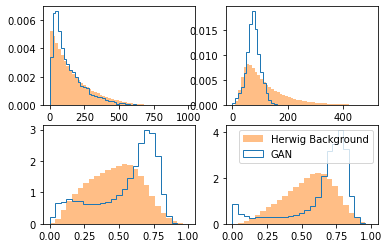

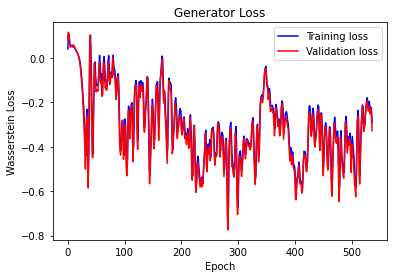

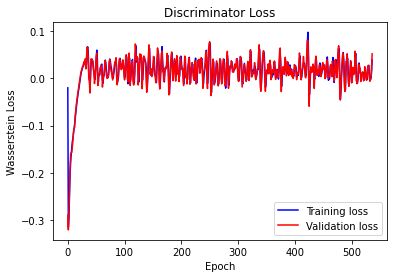

 51%|████████████████████████████████████████▎                                      | 510/1000 [56:26<42:20,  5.18s/it]


Epoch 510:

Generator training loss: -0.29566150065002544
Discriminator training loss: 0.002422356606157983

Generator validation loss: -0.3256077417096154
Discriminator validation loss: 0.007080177690277494


 52%|█████████████████████████████████████████                                      | 520/1000 [57:16<40:23,  5.05s/it]


Epoch 520:

Generator training loss: -0.4307626530609496
Discriminator training loss: -0.009637669650990454

Generator validation loss: -0.4873591702981073
Discriminator validation loss: 0.0017256243240286703


 53%|█████████████████████████████████████████▊                                     | 530/1000 [58:07<39:25,  5.03s/it]


Epoch 530:

Generator training loss: -0.5329205289564497
Discriminator training loss: 0.028979570675155282

Generator validation loss: -0.5511387796675573
Discriminator validation loss: 0.028060631918125464


 54%|██████████████████████████████████████████▋                                    | 540/1000 [58:56<37:59,  4.95s/it]


Epoch 540:

Generator training loss: -0.18541113751344993
Discriminator training loss: 0.011933884374271567

Generator validation loss: -0.2097207087962354
Discriminator validation loss: 0.014788467688944007


 55%|███████████████████████████████████████████▍                                   | 550/1000 [59:46<37:16,  4.97s/it]


Epoch 550:

Generator training loss: -0.5377070984390916
Discriminator training loss: 0.016299301367129017

Generator validation loss: -0.5122152947988666
Discriminator validation loss: 0.01149243623262546


 56%|███████████████████████████████████████████                                  | 560/1000 [1:00:36<36:18,  4.95s/it]


Epoch 560:

Generator training loss: -0.23878498037493295
Discriminator training loss: 0.007250959041699846

Generator validation loss: -0.3048455851976989
Discriminator validation loss: 0.012607066384440318


 57%|███████████████████████████████████████████▉                                 | 570/1000 [1:01:25<35:28,  4.95s/it]


Epoch 570:

Generator training loss: -0.4369790814613384
Discriminator training loss: 0.0042094105187627925

Generator validation loss: -0.38187465120534425
Discriminator validation loss: -0.011059980953997765


 58%|████████████████████████████████████████████▋                                | 580/1000 [1:02:14<34:22,  4.91s/it]


Epoch 580:

Generator training loss: -0.23224266203211957
Discriminator training loss: 0.018893954016091244

Generator validation loss: -0.32639278740179345
Discriminator validation loss: 0.030235929979530514


 59%|█████████████████████████████████████████████▍                               | 590/1000 [1:03:04<33:43,  4.94s/it]


Epoch 590:

Generator training loss: -0.36001622448853454
Discriminator training loss: -0.009301411366521805

Generator validation loss: -0.2875089054224921
Discriminator validation loss: -0.00810393330747964


 60%|██████████████████████████████████████████████                               | 599/1000 [1:03:48<32:55,  4.93s/it]


Epoch 600:

Generator training loss: -0.3821905239846537
Discriminator training loss: 0.031257411658183715

Generator validation loss: -0.4494577792824292
Discriminator validation loss: 0.025642787938418447

Epoch 600:


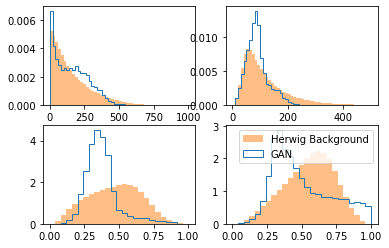

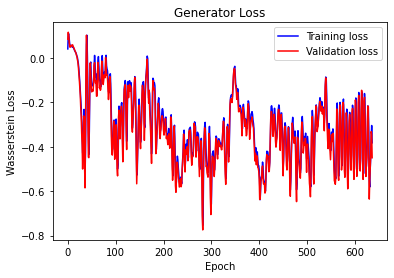

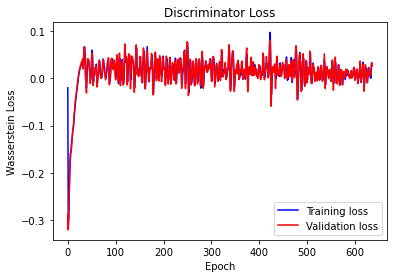

 61%|██████████████████████████████████████████████▉                              | 610/1000 [1:04:43<32:27,  4.99s/it]


Epoch 610:

Generator training loss: -0.3624747946776979
Discriminator training loss: 0.029139409506298435

Generator validation loss: -0.4725745505973941
Discriminator validation loss: 0.013927078664638713


 62%|███████████████████████████████████████████████▋                             | 620/1000 [1:05:33<31:39,  5.00s/it]


Epoch 620:

Generator training loss: -0.597839667578864
Discriminator training loss: 0.01973415082769056

Generator validation loss: -0.4740557790291114
Discriminator validation loss: 0.015896479381614776


 63%|████████████████████████████████████████████████▌                            | 630/1000 [1:06:24<31:06,  5.04s/it]


Epoch 630:

Generator training loss: -0.6809270673436545
Discriminator training loss: -0.006708496709443403

Generator validation loss: -0.7830051476838159
Discriminator validation loss: 4.136442067483287e-05


 64%|█████████████████████████████████████████████████▎                           | 640/1000 [1:07:15<30:51,  5.14s/it]


Epoch 640:

Generator training loss: -0.6600451433593458
Discriminator training loss: 0.00887246962547529

Generator validation loss: -0.5938438817125852
Discriminator validation loss: 0.014899071300622709


 65%|██████████████████████████████████████████████████                           | 650/1000 [1:08:08<30:45,  5.27s/it]


Epoch 650:

Generator training loss: -0.33619000025785684
Discriminator training loss: 0.00513948560667918

Generator validation loss: -0.35399389706674167
Discriminator validation loss: 0.007247310996315152


 66%|██████████████████████████████████████████████████▊                          | 660/1000 [1:09:00<29:12,  5.16s/it]


Epoch 660:

Generator training loss: -0.45628413639433396
Discriminator training loss: -0.00507876417835431

Generator validation loss: -0.4169200072523023
Discriminator validation loss: -0.005598603251588638


 67%|███████████████████████████████████████████████████▌                         | 670/1000 [1:09:51<28:10,  5.12s/it]


Epoch 670:

Generator training loss: -0.3127843374437322
Discriminator training loss: -0.00379153890868021

Generator validation loss: -0.4764434402106238
Discriminator validation loss: 0.007423077596181653


 68%|████████████████████████████████████████████████████▎                        | 680/1000 [1:10:42<26:54,  5.05s/it]


Epoch 680:

Generator training loss: -0.2801474145527094
Discriminator training loss: -0.001665283008317159

Generator validation loss: -0.3476487434789783
Discriminator validation loss: 0.005002894371053296


 69%|█████████████████████████████████████████████████████▏                       | 690/1000 [1:11:33<26:20,  5.10s/it]


Epoch 690:

Generator training loss: -0.550563637838989
Discriminator training loss: 0.010663073367220414

Generator validation loss: -0.5312059609616389
Discriminator validation loss: 0.015954036120569608


 70%|█████████████████████████████████████████████████████▊                       | 699/1000 [1:12:19<25:35,  5.10s/it]


Epoch 700:

Generator training loss: -0.7488397613900607
Discriminator training loss: 0.037976177088648165

Generator validation loss: -0.8101312488806053
Discriminator validation loss: 0.03714681467896358

Epoch 700:


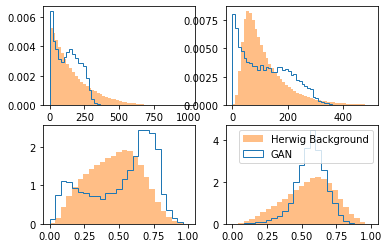

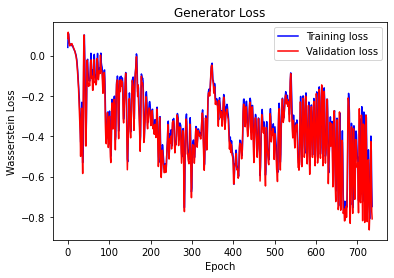

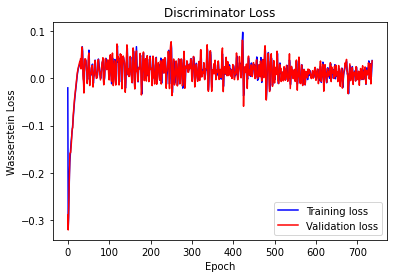

 71%|██████████████████████████████████████████████████████▋                      | 710/1000 [1:13:15<24:34,  5.08s/it]


Epoch 710:

Generator training loss: -0.5546503617463867
Discriminator training loss: -0.0013869893485460752

Generator validation loss: -0.6300431529029471
Discriminator validation loss: -0.006003519604135243


 72%|███████████████████████████████████████████████████████▍                     | 720/1000 [1:14:06<23:47,  5.10s/it]


Epoch 720:

Generator training loss: -0.4491855770838065
Discriminator training loss: 0.015243780444560812

Generator validation loss: -0.4624707835619567
Discriminator validation loss: 0.019729504460987986


 73%|████████████████████████████████████████████████████████▏                    | 730/1000 [1:14:57<22:56,  5.10s/it]


Epoch 730:

Generator training loss: -0.5155461563275812
Discriminator training loss: 0.013538632146293542

Generator validation loss: -0.5883756485141691
Discriminator validation loss: 0.0076065984200094595


 74%|████████████████████████████████████████████████████████▉                    | 740/1000 [1:15:48<21:59,  5.07s/it]


Epoch 740:

Generator training loss: -0.46326412863092997
Discriminator training loss: 0.013634244722372704

Generator validation loss: -0.6591341935220312
Discriminator validation loss: 0.003924751833661414


 75%|█████████████████████████████████████████████████████████▊                   | 750/1000 [1:16:39<21:13,  5.09s/it]


Epoch 750:

Generator training loss: -0.6206995758528266
Discriminator training loss: 0.025046401347931922

Generator validation loss: -0.7961179042448763
Discriminator validation loss: 0.013680785924929087


 76%|██████████████████████████████████████████████████████████▌                  | 760/1000 [1:17:30<20:20,  5.09s/it]


Epoch 760:

Generator training loss: -0.645121526034152
Discriminator training loss: 0.015204904700427912

Generator validation loss: -0.5962198366884326
Discriminator validation loss: 0.01815422022425127


 77%|███████████████████████████████████████████████████████████▎                 | 770/1000 [1:18:21<19:36,  5.12s/it]


Epoch 770:

Generator training loss: -0.42936020332281705
Discriminator training loss: -0.0013747400905981646

Generator validation loss: -0.5248531264359834
Discriminator validation loss: 0.009036109881040442


 78%|████████████████████████████████████████████████████████████                 | 780/1000 [1:19:12<18:33,  5.06s/it]


Epoch 780:

Generator training loss: -0.4245415963436085
Discriminator training loss: 0.0013894548619362945

Generator validation loss: -0.44347650618826756
Discriminator validation loss: 0.016541341365482964


 79%|████████████████████████████████████████████████████████████▊                | 790/1000 [1:20:02<17:47,  5.08s/it]


Epoch 790:

Generator training loss: -0.46089799343888227
Discriminator training loss: 0.014621904846411224

Generator validation loss: -0.645502053811902
Discriminator validation loss: 0.01168849858165276


 80%|█████████████████████████████████████████████████████████████▌               | 799/1000 [1:20:48<16:51,  5.03s/it]


Epoch 800:

Generator training loss: -0.15836124341995989
Discriminator training loss: -0.011471018095590941

Generator validation loss: -0.20123658866667357
Discriminator validation loss: -0.0036339882501691093

Epoch 800:


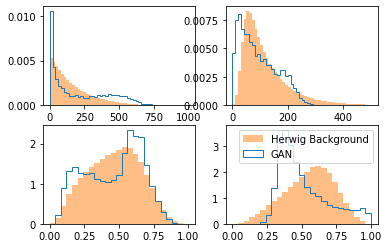

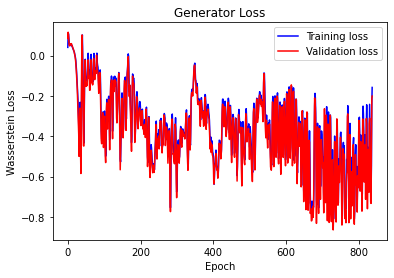

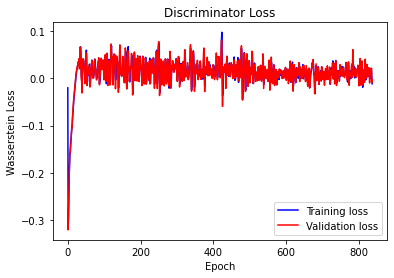

 81%|██████████████████████████████████████████████████████████████▎              | 810/1000 [1:21:44<16:13,  5.12s/it]


Epoch 810:

Generator training loss: -0.6117793653017837
Discriminator training loss: -0.0017893620244460499

Generator validation loss: -0.7053118118497191
Discriminator validation loss: -0.008812051819881699


 82%|███████████████████████████████████████████████████████████████▏             | 820/1000 [1:22:35<15:08,  5.05s/it]


Epoch 820:

Generator training loss: -0.22677396840410805
Discriminator training loss: 0.028799149979960654

Generator validation loss: -0.3175543297509678
Discriminator validation loss: 0.04241885054001554


 83%|███████████████████████████████████████████████████████████████▉             | 830/1000 [1:23:26<14:20,  5.06s/it]


Epoch 830:

Generator training loss: -0.2556725428974042
Discriminator training loss: 0.03140720381751699

Generator validation loss: -0.3512389899277296
Discriminator validation loss: 0.02355831404995234


 84%|████████████████████████████████████████████████████████████████▋            | 840/1000 [1:24:16<13:24,  5.03s/it]


Epoch 840:

Generator training loss: -0.21887846225923527
Discriminator training loss: 0.014367459124392166

Generator validation loss: -0.22954536156087627
Discriminator validation loss: 0.011707631447428807


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [1:25:07<12:39,  5.07s/it]


Epoch 850:

Generator training loss: -0.155445704246805
Discriminator training loss: -0.0013144310756555955

Generator validation loss: -0.22050018229934035
Discriminator validation loss: 0.018067596442797068


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [1:25:58<11:57,  5.13s/it]


Epoch 860:

Generator training loss: -0.48627753922196687
Discriminator training loss: 0.002204190508233045

Generator validation loss: -0.491129604030828
Discriminator validation loss: 0.00047606363206468215


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [1:26:48<10:53,  5.03s/it]


Epoch 870:

Generator training loss: -0.14577189578466077
Discriminator training loss: 0.023391750128754867

Generator validation loss: -0.18865775329167725
Discriminator validation loss: 0.01831806861398528


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [1:27:39<10:06,  5.05s/it]


Epoch 880:

Generator training loss: -0.38429770468036983
Discriminator training loss: 0.008527314895612908

Generator validation loss: -0.5372864188718014
Discriminator validation loss: 0.010073316546889846


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [1:28:29<09:11,  5.01s/it]


Epoch 890:

Generator training loss: -0.18054741533483312
Discriminator training loss: -0.0007259399644402937

Generator validation loss: -0.13574059698425356
Discriminator validation loss: -0.010428832424041188


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [1:29:14<08:28,  5.04s/it]


Epoch 900:

Generator training loss: -0.479627503967676
Discriminator training loss: 0.011504385863312951

Generator validation loss: -0.5834155517523406
Discriminator validation loss: 0.007019103957973726

Epoch 900:


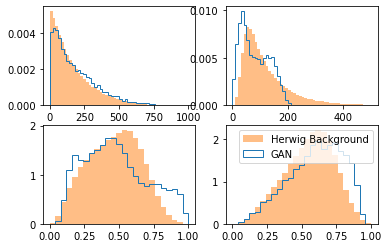

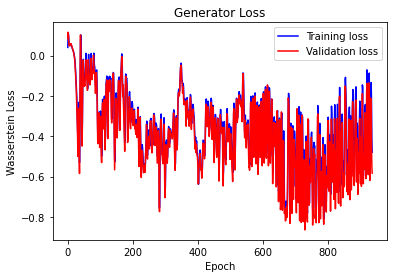

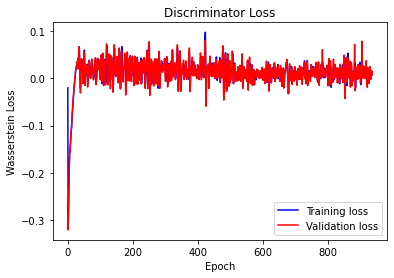

 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [1:30:10<07:31,  5.01s/it]


Epoch 910:

Generator training loss: -0.1315820296574893
Discriminator training loss: 0.008821691499443396

Generator validation loss: -0.3600329558868877
Discriminator validation loss: 0.011440874709075958


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [1:31:00<06:43,  5.04s/it]


Epoch 920:

Generator training loss: -0.14111675364805049
Discriminator training loss: 0.02508279531206516

Generator validation loss: -0.3089114720704126
Discriminator validation loss: 0.03633278060215907


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [1:31:51<05:52,  5.03s/it]


Epoch 930:

Generator training loss: -0.4740749400495831
Discriminator training loss: 0.027110526712657117

Generator validation loss: -0.5834508171824159
Discriminator validation loss: 0.02077703557328367


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [1:32:41<05:01,  5.02s/it]


Epoch 940:

Generator training loss: -0.31947360541976866
Discriminator training loss: -0.0017934739020536335

Generator validation loss: -0.454480062498421
Discriminator validation loss: 0.0004566532910847273


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [1:33:31<04:12,  5.06s/it]


Epoch 950:

Generator training loss: -0.4915442207797629
Discriminator training loss: 0.012279120412403657

Generator validation loss: -0.5838279196473418
Discriminator validation loss: 0.015126667832803042


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [1:34:22<03:21,  5.04s/it]


Epoch 960:

Generator training loss: -0.4271131364699921
Discriminator training loss: 0.01774411948498824

Generator validation loss: -0.606083595361866
Discriminator validation loss: 0.019868182468792944


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [1:35:12<02:30,  5.01s/it]


Epoch 970:

Generator training loss: -0.41074752547050436
Discriminator training loss: -0.00555212673449016

Generator validation loss: -0.44218607246875763
Discriminator validation loss: 0.01855650357711205


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [1:36:02<01:40,  5.04s/it]


Epoch 980:

Generator training loss: -0.3824730265498813
Discriminator training loss: 0.006204083939491647

Generator validation loss: -0.5598540902137756
Discriminator validation loss: -0.00839652910401098


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [1:36:52<00:50,  5.03s/it]


Epoch 990:

Generator training loss: -0.4768800437450409
Discriminator training loss: 0.01502384718697399

Generator validation loss: -0.5424034248610012
Discriminator validation loss: 0.00500899672451702


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [1:37:37<00:05,  5.02s/it]


Epoch 1000:

Generator training loss: -0.5300961273615478
Discriminator training loss: 0.015575822181723157

Generator validation loss: -0.5819776878982293
Discriminator validation loss: 0.027504134709473518

Epoch 1000:


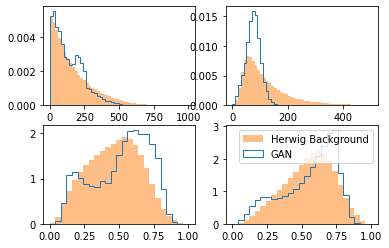

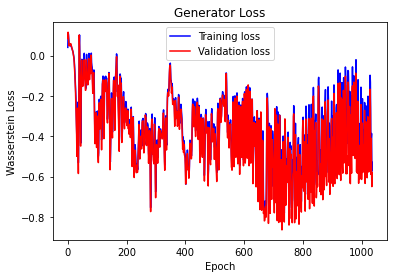

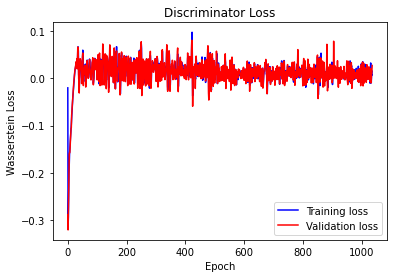

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:37:43<00:00,  5.86s/it]


In [33]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080